In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Seeding for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [4]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [6]:
kaggle_credentails = json.load(open("kaggle.json"))

In [7]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [8]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:26<00:00, 141MB/s]
100% 2.04G/2.04G [00:26<00:00, 83.4MB/s]


In [9]:
!ls

drive  kaggle.json  plantvillage-dataset.zip  sample_data


In [14]:
# Unzip the downloaded dataset
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [15]:
print(os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])


['color', 'grayscale', 'segmented']
38
['Tomato___Early_blight', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Peach___Bacterial_spot', 'Tomato___Septoria_leaf_spot']
38
['Tomato___Early_blight', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Peach___Bacterial_spot', 'Tomato___Septoria_leaf_spot']
38
['Tomato___Early_blight', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Peach___Bacterial_spot', 'Tomato___Septoria_leaf_spot']


In [16]:
print(len(os.listdir("plantvillage dataset/color/Grape___healthy")))
print(os.listdir("plantvillage dataset/color/Grape___healthy")[:5])

423
['61a531ba-3d52-4af3-8828-c2dbba4d3b1d___Mt.N.V_HL 8941.JPG', 'fdf4cdd9-cb41-42de-a73e-87301576fade___Mt.N.V_HL 9000.JPG', 'f0a897af-a598-493e-962b-849709155dfd___Mt.N.V_HL 6091.JPG', 'ca090e78-ff31-4715-82eb-b63e20b0e156___Mt.N.V_HL 9081.JPG', '605f6929-3bb5-419c-8bee-eccc39128245___Mt.N.V_HL 9059.JPG']


In [17]:
# Dataset Path
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


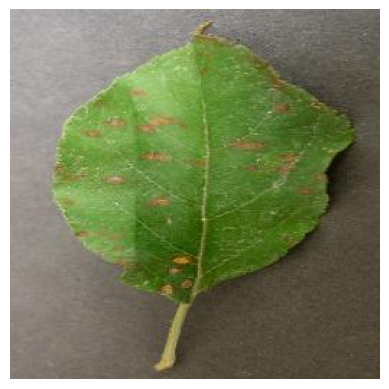

In [19]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [20]:
# Image Parameters
img_size = 224
batch_size = 32

In [21]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [22]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [23]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


Convolutional Neural Network

In [24]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [25]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [26]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model Training

In [27]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5
1358/1358 [==============================] - 114s 79ms/step - loss: 0.9778 - accuracy: 0.7320 - val_loss: 0.4629 - val_accuracy: 0.8561
Epoch 2/5
1358/1358 [==============================] - 107s 79ms/step - loss: 0.2846 - accuracy: 0.9122 - val_loss: 0.4221 - val_accuracy: 0.8746
Epoch 3/5
1358/1358 [==============================] - 108s 79ms/step - loss: 0.1352 - accuracy: 0.9547 - val_loss: 0.4723 - val_accuracy: 0.8791
Epoch 4/5
1358/1358 [==============================] - 106s 78ms/step - loss: 0.0838 - accuracy: 0.9725 - val_loss: 0.5969 - val_accuracy: 0.8576
Epoch 5/5
1358/1358 [==============================] - 105s 77ms/step - loss: 0.0705 - accuracy: 0.9771 - val_loss: 0.5855 - val_accuracy: 0.8780


Model Evaluation

In [28]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 [==============================] - 20s 59ms/step - loss: 0.5855 - accuracy: 0.8780
Validation Accuracy: 87.80%


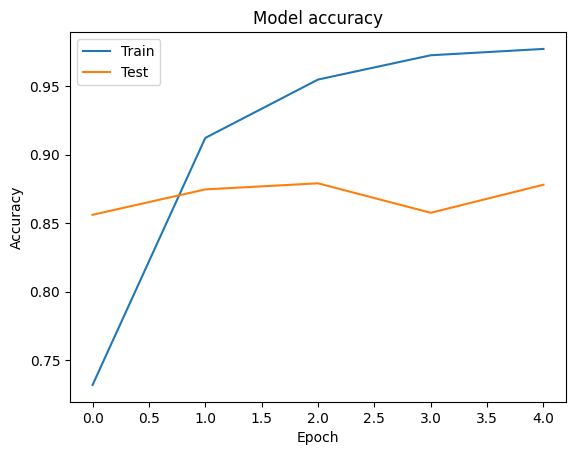

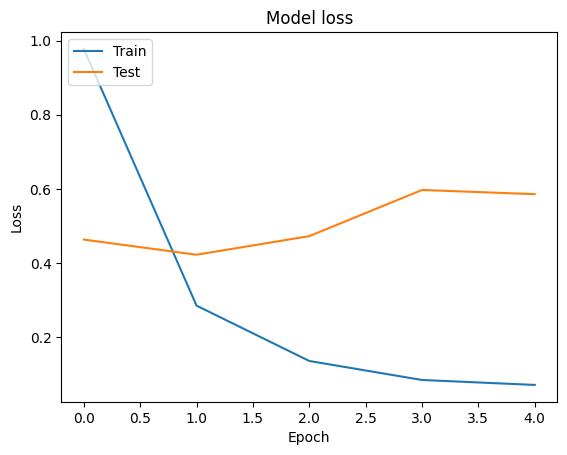

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Building a Predictive System

In [30]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


In [31]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [32]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [ ]:
# Example Usage
image_path = '/content/test_apple_black_rot.JPG'
#image_path = '/content/test_blueberry_healthy.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 265ms/step
Predicted Class Name: Apple___Black_rot


In [35]:
model.save('/content/drive/MyDrive/Plant Project/plant_disease_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
